In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-sjmyh1sj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-sjmyh1sj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=6917595d8589a92e3bd5f9934f0d365e5ef8be65a755736750ff273fb6d23d99
  Stored in directory: /tmp/pip-ephem-wheel-cache-pqliqcpg/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-09-09 15:22:57--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.165.160.120, 3.165.160.69, 3.165.160.106, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.165.160.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   253MB/s    in 11s     

2024-09-09 15:23:08 (219 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
import torch
import torchvision

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint="sam_vit_h_4b8939.pth").to(
    device=DEVICE
)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [5]:
mask_generator = SamAutomaticMaskGenerator(sam)

import cv2

image_bgr = cv2.imread("/content/sem.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)

In [6]:
!pip install -q jupyter_bbox_widget dataclasses-json supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 36.4 MB/s eta 0:00:00


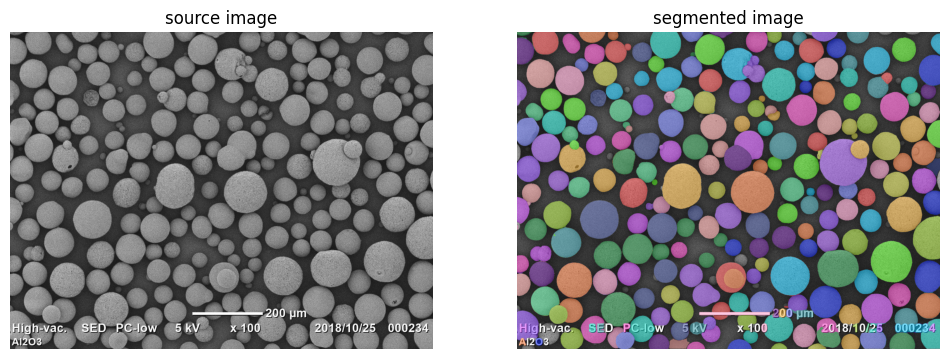

In [7]:
import supervision as sv

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=["source image", "segmented image"],
)

In [16]:
import supervision as sv
import numpy as np

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

segment_data = []
for i, mask in enumerate(detections.mask):
    coordinates = np.column_stack(np.where(mask))
    area = len(coordinates)
    segment_data.append({"segment_id": i, "coordinates": coordinates, "area": area})

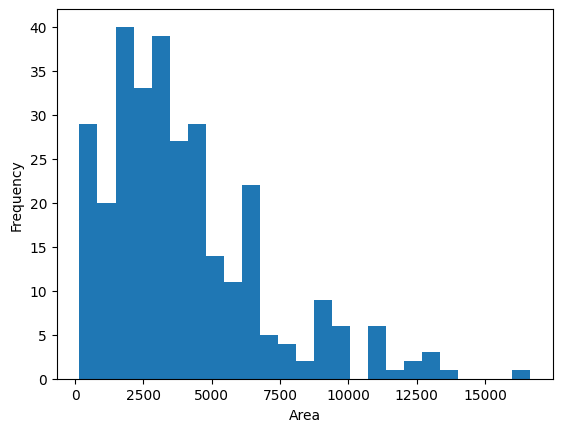

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([segment["area"] for segment in segment_data], bins=25)
ax.set_xlabel("Area")
ax.set_ylabel("Frequency")
plt.show()

In [80]:
from scipy.spatial import ConvexHull


def extract_boundary_points(coordinates):
    hull = ConvexHull(coordinates)
    boundary_points = coordinates[hull.vertices]
    return boundary_points

In [81]:
boundary_points = extract_boundary_points(segment_data[0]["coordinates"])

In [82]:
import math


def calculate_circularity(points):
    x_center = sum(p[0] for p in points) / len(points)
    y_center = sum(p[1] for p in points) / len(points)
    radii = [math.sqrt((p[0] - x_center) ** 2 + (p[1] - y_center) ** 2) for p in points]
    mean_radius = sum(radii) / len(radii)
    circularity = min(radii) / max(radii)

    return circularity, x_center, y_center, min(radii), max(radii)

In [83]:
circularity, x_center, y_center, rmin, rmax = calculate_circularity(boundary_points)

(732.8000000000001, 1276.8)

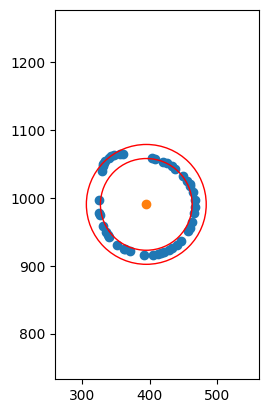

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1])
ax.scatter(x_center, y_center)
min_circle = plt.Circle(
    (x_center, y_center), rmin, color="red", fill=False, label="Min Circle"
)
ax.add_artist(min_circle)
max_circle = plt.Circle(
    (x_center, y_center), rmax, color="red", fill=False, label="Min Circle"
)
ax.add_artist(max_circle)
ax.set_aspect("equal")
ax.set_xlim(boundary_points[:, 0].min() * 0.8, boundary_points[:, 0].max() * 1.2)
ax.set_ylim(boundary_points[:, 1].min() * 0.8, boundary_points[:, 1].max() * 1.2)

In [85]:
def get_circularity(points):
    boundary_points = extract_boundary_points(points)
    circularity, _, _, _, _ = calculate_circularity(boundary_points)
    return circularity

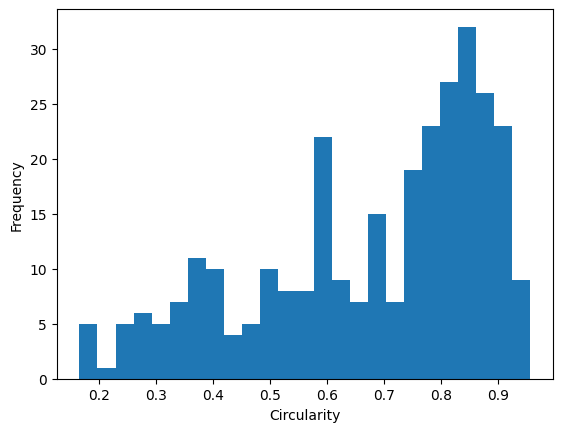

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([get_circularity(segment["coordinates"]) for segment in segment_data], bins=25)
ax.set_xlabel("Circularity")
ax.set_ylabel("Frequency")
plt.show()

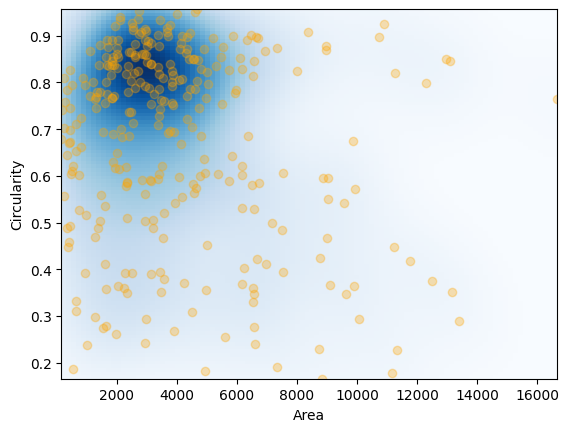

In [96]:
from scipy.stats import gaussian_kde

fig = plt.figure()
ax = fig.add_subplot(111)
x = [segment["area"] for segment in segment_data]
y = [get_circularity(segment["coordinates"]) for segment in segment_data]

xy = np.vstack([x, y])
kde = gaussian_kde(xy)

xx, yy = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

im = ax.imshow(
    zz,
    cmap="Blues",
    origin="lower",
    aspect="auto",
    extent=[min(x), max(x), min(y), max(y)],
)


ax.scatter(x, y, c="orange", alpha=0.3)

plt.xlabel("Area")
plt.ylabel("Circularity")
plt.show()